In [27]:
import os
from PIL import Image
import numpy as np

In [28]:
first_class_train =  'data/1class_train/'
second_class_train =  'data/2class_train/'
third_class_train =  'data/3class_train/'

first_class_test = 'data/1class_test/'
second_class_test = 'data/2class_test/'
third_class_test = 'data/3class_test/'

In [29]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

def norm_image_(img):
    print(type(img))
    return (img - 127) / 255

In [30]:
def imgToArray(image):
    x=image.convert('L')
    y=np.asarray(x.getdata(),dtype=np.float64).reshape((x.size[1],x.size[0]))
    y=np.asarray(y,dtype=np.uint8) 
    return (y - 127) / 255
    

In [31]:
def resize_image(img, size):

    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=Image.BICUBIC)

    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad


In [32]:
new_size = 224

def getImages_wo_resize(path):
    names = os.listdir(path)
    img_arr = []
    for name in names:
        p = path + name
        img = Image.open(p)
        img_arr.append(img)
    return img_arr

def getImages(path):
    names = os.listdir(path)
    img_arr = []
    for name in names:
        p = path + name
        try:
            img = Image.open(p)
            img_arr.append(imgToArray(resize_image(norm_image(img), new_size)))
        except OSError:
            print('remove ' + p)
            os.remove(p)
            print('remove ' + 'data/images/' + name)
            os.remove('data/images/' + name)
            
    return img_arr


def resize(img, size):
    #wpercent = basewidth / img.size[0]
    #hsize = int((float(img.size[1]) * float(wpercent)))
    #return img.resize((basewidth,hsize), Image.ANTIALIAS)
    return img.resize((size, size), Image.ANTIALIAS)

In [33]:
first_class_train_img = getImages(first_class_train)
second_class_train_img = getImages(second_class_train)
third_class_train_img = getImages(third_class_train)

first_class_test_img = getImages(first_class_test)
second_class_test_img = getImages(second_class_test)
third_class_test_img = getImages(third_class_test)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in absolute
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in absolute


In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

img_rows, img_cols = 224, 224 


Using Theano backend.


In [35]:
# make (X_train, y_train), (X_test, y_test)

import numpy as np

X_train = np.array(first_class_train_img + second_class_train_img +third_class_train_img)
y_train = np.array([np.repeat(0, len(first_class_train_img))] +
                    [np.repeat(1, len(second_class_train_img))] +
                    [np.repeat(2, len(second_class_train_img))])

X_test = np.array(first_class_test_img+ second_class_test_img+ third_class_test_img)
y_test = np.array([np.repeat(0, len(first_class_test_img))] +
                    [np.repeat(1, len(second_class_test_img))] +
                    [np.repeat(2, len(second_class_test_img))])

                              
len_train = len(first_class_train_img) + len(second_class_train_img) + len(third_class_train_img)
print(len(first_class_train_img))
print(X_train.shape)
print(len_train)

#X_train  = X_train.reshape(len_train)
y_train = y_train.reshape(len_train)


len_test = len(first_class_test_img) + len(second_class_test_img) + len(third_class_test_img)
#X_test = X_test.reshape(len_test)
y_test = y_test.reshape(len_test)

y_test.shape

5000
(15000, 224, 224)
15000


(1500,)

In [36]:
img_rows, img_cols = 224, 224


In [37]:
#theano

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

model = Sequential()
model.add(Convolution2D(20, 5, 5, border_mode='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(20, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
nb_epoch = 12

res = model.fit(X_train, Y_train, batch_size=128, nb_epoch=nb_epoch, verbose=1, validation_data=(X_test, Y_test), shuffle=True)
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 15000 samples, validate on 1500 samples
Epoch 1/12
15000/15000 [==============================] - 1862s - loss: 1.3081 - acc: 0.3911 - val_loss: 1.0832 - val_acc: 0.4073
Epoch 2/12
15000/15000 [==============================] - 1919s - loss: 1.0617 - acc: 0.4412 - val_loss: 1.0703 - val_acc: 0.4087
Epoch 3/12
15000/15000 [==============================] - 1947s - loss: 1.0131 - acc: 0.4882 - val_loss: 1.0832 - val_acc: 0.3987
Epoch 4/12
15000/15000 [==============================] - 1915s - loss: 0.9300 - acc: 0.5551 - val_loss: 1.1089 - val_acc: 0.3907
Epoch 5/12
15000/15000 [==============================] - 1843s - loss: 0.8211 - acc: 0.6245 - val_loss: 1.1648 - val_acc: 0.3793
Epoch 6/12
15000/15000 [==============================] - 1862s - loss: 0.7039 - acc: 0.6932 - val_loss: 1.3006 - val_acc: 0.3893
Epoch 7/12
15000/15000 [==============================] - 1928s - loss: 0.5962 - acc: 0.7455 - val_loss: 1.2936 - val_acc: 0.4027
Epoch 8/12
15000/15000 [=================

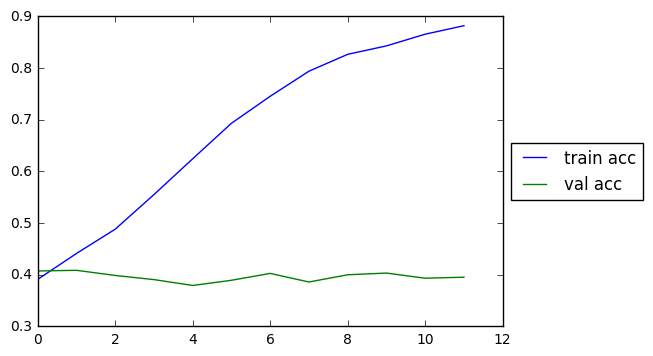

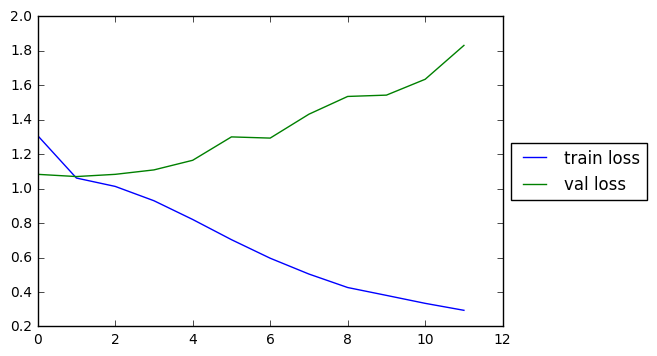

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range(nb_epoch)

plt.plot(x, res.history['acc'], label="train acc")
plt.plot(x, res.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res.history['loss'], label="train loss")
plt.plot(x, res.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))